In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_files
#from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D
from keras.layers import Activation, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras import backend as K

2024-03-01 12:37:51.576303: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 12:37:51.576389: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-01 12:37:51.765993: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_data='/kaggle/input/fruits/fruits-360_dataset/fruits-360/Training'

In [3]:
test_data='/kaggle/input/fruits/fruits-360_dataset/fruits-360/Test'

In [5]:
def get_data(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels

X_train, Y_train, labels = get_data(train_data)
X_test, Y_test,_ = get_data(test_data)

In [6]:
from keras.utils import to_categorical

In [7]:
Y_train = to_categorical(Y_train, 131)
Y_test = to_categorical(Y_test, 131)

In [8]:
X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=33)
Y_train, Y_val = train_test_split(Y_train, test_size=0.2, random_state=33)

In [9]:
def convert_image_to_array(files):
    images_as_array=[]
    for file in files:
        images_as_array.append(img_to_array(load_img(file)))
    return images_as_array

In [10]:
X_train = np.array(convert_image_to_array(X_train))
X_val = np.array(convert_image_to_array(X_val))
X_test = np.array(convert_image_to_array(X_test))

In [11]:
X_train = X_train.astype('float32')/255
X_val = X_val.astype('float32')/255
X_test = X_test.astype('float32')/255

In [12]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense, Attention, Input

# Define the CNN model with attention
input_layer = Input(shape=(100, 100, 3))

# Convolutional layers
x = Conv2D(filters=16, kernel_size=2, padding='same')(input_layer)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=32, kernel_size=2, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=64, kernel_size=2, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=128, kernel_size=2, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)

# Applying attention after the last convolutional layer
attention = Attention()([x, x])

# Fully connected layers
x = Dropout(0.3)(attention)
x = Flatten()(x)
x = Dense(150, activation='relu')(x)
x = Dropout(0.4)(x)
output_layer = Dense(131, activation='softmax')(x)

# Creating the model with attention
model_with_attention = Model(inputs=input_layer, outputs=output_layer)

# Displaying the summary of the model
model_with_attention.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 100, 100, 16)         208       ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 100, 100, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 50, 50, 16)           0         ['activation[0][0]']          
 D)                                                                                           

In [13]:
from keras.optimizers import SGD, Adam, RMSprop

optimizer = Adam()
model_with_attention.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [14]:
checkpointer = ModelCheckpoint(filepath = 'cnn_from_scratch_fruits.hdf5', verbose = 1, save_best_only = True)

# fitting model using above defined layers 
history = model_with_attention.fit(X_train,Y_train,
        batch_size = 128,
        epochs=25,
        validation_data=(X_val, Y_val),
        callbacks = [checkpointer],
        verbose=2, shuffle=True)

Epoch 1/25


I0000 00:00:1709297649.718464     109 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_loss improved from inf to 0.18225, saving model to cnn_from_scratch_fruits.hdf5
424/424 - 22s - loss: 2.2274 - accuracy: 0.4334 - val_loss: 0.1823 - val_accuracy: 0.9581 - 22s/epoch - 52ms/step
Epoch 2/25


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.18225 to 0.04129, saving model to cnn_from_scratch_fruits.hdf5
424/424 - 10s - loss: 0.4154 - accuracy: 0.8623 - val_loss: 0.0413 - val_accuracy: 0.9910 - 10s/epoch - 25ms/step
Epoch 3/25

Epoch 3: val_loss improved from 0.04129 to 0.02881, saving model to cnn_from_scratch_fruits.hdf5
424/424 - 11s - loss: 0.2572 - accuracy: 0.9127 - val_loss: 0.0288 - val_accuracy: 0.9921 - 11s/epoch - 25ms/step
Epoch 4/25

Epoch 4: val_loss improved from 0.02881 to 0.01626, saving model to cnn_from_scratch_fruits.hdf5
424/424 - 11s - loss: 0.1957 - accuracy: 0.9317 - val_loss: 0.0163 - val_accuracy: 0.9952 - 11s/epoch - 25ms/step
Epoch 5/25

Epoch 5: val_loss improved from 0.01626 to 0.01000, saving model to cnn_from_scratch_fruits.hdf5
424/424 - 11s - loss: 0.1537 - accuracy: 0.9473 - val_loss: 0.0100 - val_accuracy: 0.9979 - 11s/epoch - 25ms/step
Epoch 6/25

Epoch 6: val_loss did not improve from 0.01000
424/424 - 11s - loss: 0.1388 - accuracy: 0.9526 - val_loss: 

In [15]:
score = model_with_attention.evaluate(X_test, Y_test)
print('Test accuracy:', score[1])

709/709 [==============================] - 3s 4ms/step - loss: 0.1014 - accuracy: 0.9838
Test accuracy: 0.9837799668312073


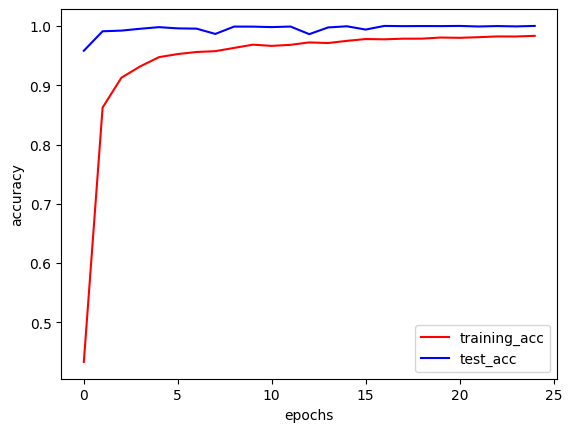

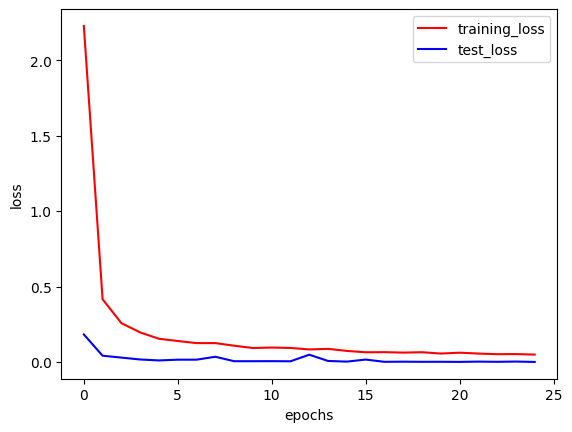

In [16]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],color = 'red',label = 'training_acc')
plt.plot(history.history['val_accuracy'],color = 'blue',label = 'test_acc')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.show()




plt.plot(history.history['loss'],color = 'red',label = 'training_loss')
plt.plot(history.history['val_loss'],color = 'blue',label = 'test_loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()


709/709 [==============================] - 2s 3ms/step


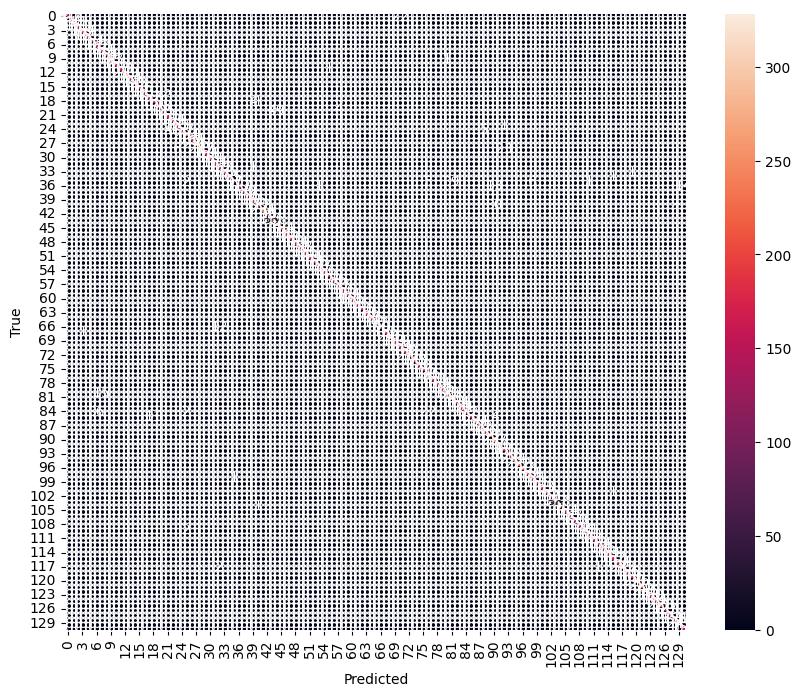

709/709 [==============================] - 3s 5ms/step - loss: 0.1014 - accuracy: 0.9838
Test accuracy is 0.9837799668312073 and test loss is 0.10136287659406662


In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


y_pred = model_with_attention.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

confusion_mtx = confusion_matrix(np.argmax(Y_test, axis=1), y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

test_loss, test_acc = model_with_attention.evaluate(X_test, Y_test)
print(f"Test accuracy is {test_acc} and test loss is {test_loss}")

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

# Predictions on test set
Y_pred = model_with_attention.predict(X_test)
# Convert predictions to one-hot encoded labels
Y_pred_labels = np.argmax(Y_pred, axis=1)
Y_true_labels = np.argmax(Y_test, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(Y_true_labels, Y_pred_labels)

# Classification Report
class_report = classification_report(Y_true_labels, Y_pred_labels)

print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(class_report)


709/709 [==============================] - 2s 3ms/step
Confusion Matrix:
[[142   0   0 ...   0   0   0]
 [  0 148   0 ...   0   0   0]
 [  0   0 160 ...   0   0   0]
 ...
 [  0   0   0 ... 158   0   0]
 [  0   0   0 ...   0 249   0]
 [  0   0   0 ...   0   0 157]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.87      0.93       164
           1       1.00      1.00      1.00       148
           2       1.00      1.00      1.00       160
           3       0.99      1.00      1.00       164
           4       1.00      1.00      1.00       161
           5       1.00      1.00      1.00       164
           6       0.81      1.00      0.89       152
           7       0.92      1.00      0.96       164
           8       1.00      1.00      1.00       164
           9       1.00      0.99      1.00       144
          10       1.00      1.00      1.00       166
          11       1.00      0.99      1.00       164
        